# Quick Assessment of Deforestation in Pacajá Pará via Sentinel-2 #

In this Jupyter Notebook I demonstrate how to use common GIS tools along with Sentinel-2 L2A data in a quick and dirty way to get rough figures of deforestation around the area of Pachama's promoted site Fazenda Pacajá in Brazil.

First, we will need the following libraries

In [4]:
import stackstac
import pystac_client
import numpy as np
import xarray as xr
import rioxarray
import rasterio
from affine import Affine
from shapely.geometry import shape, Polygon, MultiPolygon
import geopandas as gpd
import requests
from IPython.display import display
from PIL import Image
from ipywidgets import widgets
from sklearn.ensemble import RandomForestClassifier
from ipyleaflet import Map,GeoJSON, ImageOverlay, TileLayer
import matplotlib
from base64 import b64encode
from io import BytesIO
from skimage.morphology import binary_erosion, binary_dilation

We will be downloading Sentinel-2 imagery via the STAC database from element84.

To do that, we will need to provide a polygon of the ROI we want covered.

Let's load this ROI from a geojson we made via QGIS and display it  

In [5]:
roi_gdf = gpd.read_file("../res/roi.geojson")

map = Map(center=tuple(roi_gdf.geometry[0].centroid.coords)[0][::-1], zoom=9)
map.add(
    GeoJSON(data=roi_gdf.geometry[0].__geo_interface__, style={"color": "red"})
)

Map(center=[-2.474258378662231, -50.43133406603268], controls=(ZoomControl(options=['position', 'zoom_in_text'…

Now we load all Sentinel-2 Tiles covering the ROI over the entire S2 mission's lifespan until today.

In [6]:
URL = "https://earth-search.aws.element84.com/v1"
catalog = pystac_client.Client.open(URL)

items = catalog.search(
    intersects=roi_gdf.geometry[0],
    collections=["sentinel-2-l2a"],
    datetime="2015-03-01/2023-12-01"
).item_collection()

print(f"Found {len(items)} S2 tiles covering the area")

Found 564 S2 tiles covering the area


The STAC items we gathered have references to some preview pictures.

We display those with acceptable cloud coverage for a visual check.

In [7]:
nocloud_items = [
    item for item in items
    if (
        item.properties["eo:cloud_cover"] < 5
    )
]

widgets.GridBox(
    children = [
        widgets.VBox(
            children = [
                widgets.Label(item.id),
                widgets.Label(f"Cloud cover: {item.properties['eo:cloud_cover']}%"),
                widgets.Image(value=requests.get(item.assets["thumbnail"].href, stream=True).content)
            ],
            layout=widgets.Layout(border='solid',)
        )
        for item in nocloud_items[::]
    ],
    layout=widgets.Layout(
        grid_template_columns='256px ' * 4,
    )
)

GridBox(children=(VBox(children=(Label(value='S2A_22MEC_20230722_0_L2A'), Label(value='Cloud cover: 0.038407%'…

Even with a low threshold for cloud coverage, we can see that our images are generally tainted with problematic clouds.

We'll see how to deal with that in a few moments, but before that let's preview one of the miniature on a leaflet map by reprojecting it to WGS84.

In [8]:
def preview_miniature_on_map(item):
    t = item.assets["blue"].extra_fields["proj:transform"]
    da = xr.DataArray(
        data=np.array(Image.open(requests.get(item.assets["thumbnail"].href, stream=True).raw)),
        dims = ["y", "x", "band"],
    ).transpose('band', 'y', 'x').rio.write_crs(item.properties["proj:epsg"]).rio.write_transform(
        Affine(10 * 10980 / 343, *t[1:4], -10 * 10980 / 343, t[5])
    ).rio.reproject("epsg:4326")
    im = Image.fromarray(da.transpose('y', 'x', 'band').values)

    map = Map(center=tuple(roi_gdf.geometry[0].centroid.coords)[0][::-1], zoom=9)
    f = BytesIO()
    im.save(f, "png")
    data = b64encode(f.getvalue()).decode("ascii")
    imgurl = "data:image/png;base64," + data
    a,b,c,d = da.rio.bounds()
    bounds = ((d, c), (b, a))

    map.add(ImageOverlay(url = imgurl, bounds = bounds))
    map.add(
        GeoJSON(data=roi_gdf.geometry[0].__geo_interface__, style={"color": "red", "fillOpacity": 0})
    )
    display(map)

preview_miniature_on_map(nocloud_items[12])

Map(center=[-2.474258378662231, -50.43133406603268], controls=(ZoomControl(options=['position', 'zoom_in_text'…

Now we leverage the capability of a library called stackstac which helps compile those items into a standalone lazy DataArray.

Such a DataArray is useful to conduct operation in a streamlined and intuitive manner. The biggest advantage of this method is that we can make use of the Dask backend to process each chunk in parallel.

In [9]:
da = stackstac.stack(nocloud_items)
da

/home/pierre/repositories/pachama-demo/.venv/lib/python3.10/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


<xarray.DataArray 'stackstac-1495a471a99776c65dff15decaecbb31' (time: 22,
                                                                band: 32,
                                                                y: 10980,
                                                                x: 10980)>
dask.array<fetch_raster_window, shape=(22, 32, 10980, 10980), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/52)
  * time                                     (time) datetime64[ns] 2017-06-03...
    id                                       (time) <U24 'S2A_22MEC_20170603_...
  * band                                     (band) <U12 'aot' ... 'wvp-jp2'
  * x                                        (x) float64 5e+05 ... 6.098e+05
  * y                                        (y) float64 9.8e+06 ... 9.69e+06
    s2:not_vegetated_percentage              (time) float64 0.4886 ... 0.4804
    ...                                       ...
    title                                    (band) <U31 'Aerosol optical thi...
    gsd                                      (band) object None 10 ... None None
    common_name                              (band) object None 'blue' ... None
    center_wavelength                        (band) object None 0.49 ... None
    full_width_half_max                      (band) object None 0.098 ... None
    epsg                                     int64 32722
Attributes:
    spec:        RasterSpec(epsg=32722, bounds=(499980.0, 9690220.0, 609780.0...
    crs:         epsg:32722
    transform:   | 10.00, 0.00, 499980.00|\n| 0.00,-10.00, 9800020.00|\n| 0.0...
    resolution:  10.0

Now, let's get down to business.
We want to assess how much deforestation occured throughout the years.

The way to do it is to train a model that can classify a picture into vegetated areas, non-vegetated areas and other (ie. clouds, lack of data, water).
Then, a quick assessment of the deforestation process in the region is only a matter of counting vegetation pixels over the total of vegetation + non-vegetation pixels.

The good news is that we don't even need to train a model ourselves since L2A data come with a basic classification raster that include those classes we want.
We could if we wanted too, options include training a ML model such as a Random Forest on the most relevant S2 bands. But that would take far too long for what is supposed to be a quick and dirty demo.

![S2 Classification](https://i.stack.imgur.com/rk2E1.png)

Here's what a scene classification raster looks like of the area.


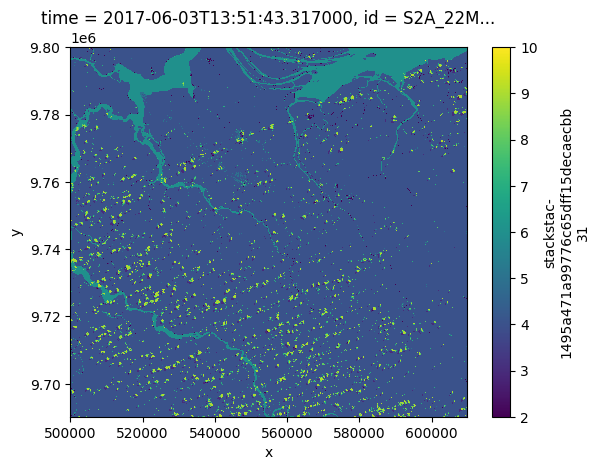

In [10]:
da.isel(time=0).sel(band="scl").plot.imshow()

We will thus focus on SCL data

In [11]:
scl_da = da.sel(band="scl")
scl_da

<xarray.DataArray 'stackstac-1495a471a99776c65dff15decaecbb31' (time: 22,
                                                                y: 10980,
                                                                x: 10980)>
dask.array<getitem, shape=(22, 10980, 10980), dtype=float64, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/52)
  * time                                     (time) datetime64[ns] 2017-06-03...
    id                                       (time) <U24 'S2A_22MEC_20170603_...
    band                                     <U12 'scl'
  * x                                        (x) float64 5e+05 ... 6.098e+05
  * y                                        (y) float64 9.8e+06 ... 9.69e+06
    s2:not_vegetated_percentage              (time) float64 0.4886 ... 0.4804
    ...                                       ...
    title                                    <U31 'Scene classification map (...
    gsd                                      object None
    common_name                              object None
    center_wavelength                        object None
    full_width_half_max                      object None
    epsg                                     int64 32722
Attributes:
    spec:        RasterSpec(epsg=32722, bounds=(499980.0, 9690220.0, 609780.0...
    crs:         epsg:32722
    transform:   | 10.00, 0.00, 499980.00|\n| 0.00,-10.00, 9800020.00|\n| 0.0...
    resolution:  10.0


The main issue is that most images are incomplete due to clouds passing by. So by doing what we proposed to do earlier we may end up comparing regions that are very different and thus introduce bias.

We will resolve this issue by compiling each year worth of data into a single raster for comparison

In [12]:
def vegetation_classes_over_time(x, axis):
    vegetation = (x == 4).any(axis=axis)
    no_vegetation = (x == 5).any(axis=axis) & ~vegetation
    return vegetation + no_vegetation * 2

reduced_scl_da = scl_da.groupby("time.year").reduce(vegetation_classes_over_time)
reduced_scl_da

<xarray.DataArray 'stackstac-1495a471a99776c65dff15decaecbb31' (year: 6,
                                                                y: 10980,
                                                                x: 10980)>
dask.array<stack, shape=(6, 10980, 10980), dtype=int64, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/22)
    band                                     <U12 'scl'
  * x                                        (x) float64 5e+05 ... 6.098e+05
  * y                                        (y) float64 9.8e+06 ... 9.69e+06
    mgrs:latitude_band                       <U1 'M'
    s2:saturated_defective_pixel_percentage  int64 0
    constellation                            <U10 'sentinel-2'
    ...                                       ...
    gsd                                      object None
    common_name                              object None
    center_wavelength                        object None
    full_width_half_max                      object None
    epsg                                     int64 32722
  * year                                     (year) int64 2017 2018 ... 2023
Attributes:
    spec:        RasterSpec(epsg=32722, bounds=(499980.0, 9690220.0, 609780.0...
    crs:         epsg:32722
    transform:   | 10.00, 0.00, 499980.00|\n| 0.00,-10.00, 9800020.00|\n| 0.0...
    resolution:  10.0

We opt for a conservative approach for each year: A pixel is considered vegetated if at some point it was vegetated during that year. The rest is either considered non-vegetated, if it was non-vegetated at some point, or other otherwise (cloud, water, nodata, etc.).

Let's visualize the results

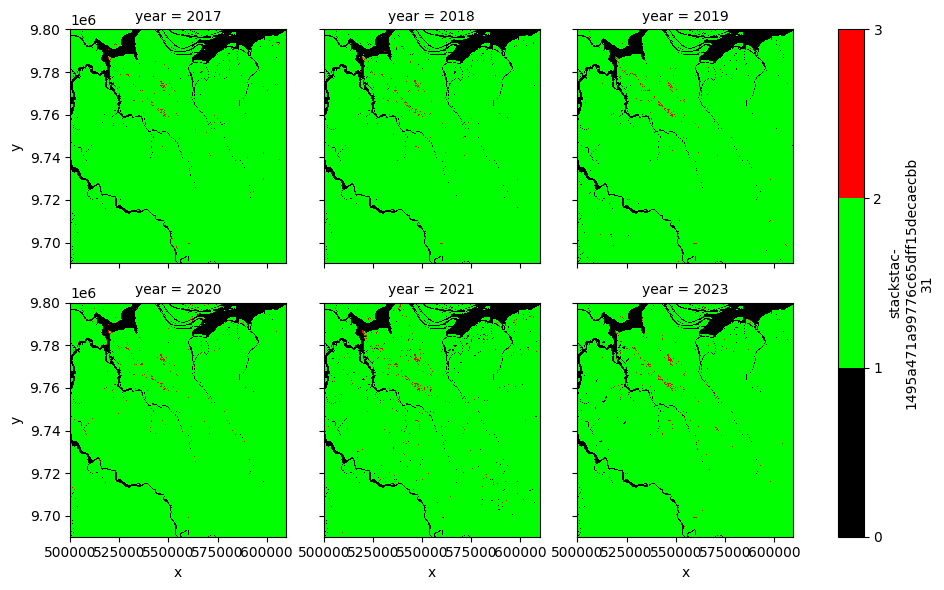

In [13]:
reduced_scl_da.plot.imshow(levels=[0, 1, 2, 3], colors=["#000000", "#00ff00", "#ff0000"], col="year", col_wrap=3)

Clouds seem to have been successfuly filtered for the most part.

From 2017 to 2023 we notice that some areas are more prone to deforestation than others, especially areas close to already deforested areas, which makes sense.

To make the phenomenon more apparent, let's compute the raster showing forest difference between 2017 and 2023.

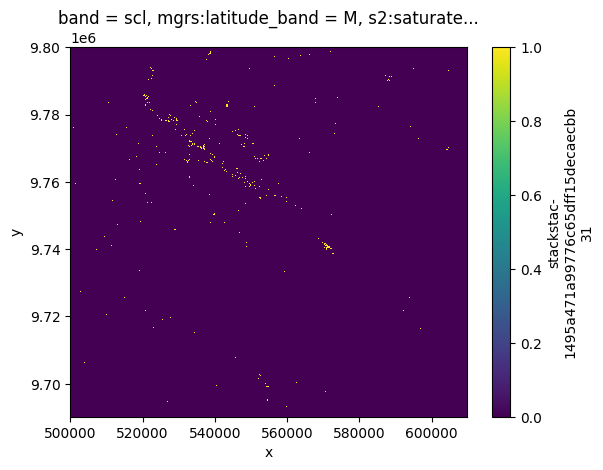

In [14]:
lost_forest = ((reduced_scl_da.sel(year=2017) == 1) & (reduced_scl_da.sel(year=2023) == 2))
lost_forest.plot.imshow()

Let's erase spurious pixels and expand around the more affected area using some dilation and erosion morphological operations.
Then let's create polygons from the resulting mask.

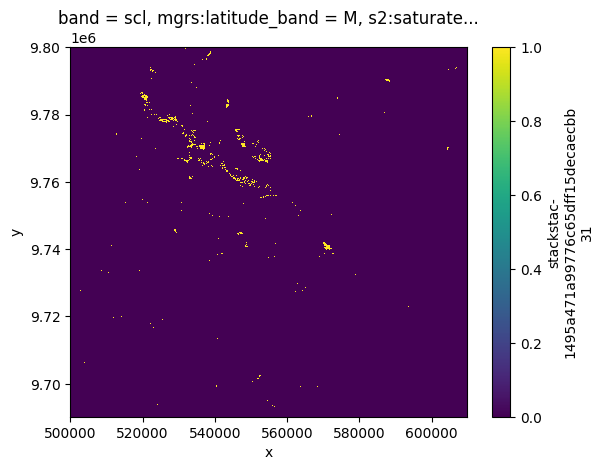

In [15]:
lost_forest_areas = lost_forest.copy()
y,x = np.ogrid[-3:7-3, -3:7-3]
mask = x*x + y*y <= 3*3
lost_forest_areas.values = binary_dilation(lost_forest_areas.values, footprint=mask)
for i in range(2):
    lost_forest_areas.values = binary_erosion(lost_forest_areas.values, footprint=mask)
for i in range(3):
    lost_forest_areas.values = binary_dilation(lost_forest_areas.values, footprint=mask)
lost_forest_areas.plot.imshow()

In [16]:
lost_forest_gdf = gpd.GeoDataFrame(
    geometry=[shape(g) for g,_ in rasterio.features.shapes(
            lost_forest_areas.astype(np.uint8),
            lost_forest_areas.astype(np.uint8),
            transform = da.rio.transform(),
        )
    ],
    crs=da["proj:epsg"].values,
).to_crs("epsg:4326").dissolve().simplify(tolerance=0.0001)
lost_forest_gdf

0    MULTIPOLYGON (((-50.98691 -2.75810, -50.98673 ...
dtype: geometry

Let's plot those deforested areas on a leaflet map to better identify which sites are the most affected.

In [17]:
tms = TileLayer(
        url="http://c.tiles.maps.eox.at/wmts/1.0.0/s2cloudless_3857/default/GoogleMapsCompatible/{z}/{y}/{x}.jpg",
)
map = Map(center=tuple(roi_gdf.geometry[0].centroid.coords)[0][::-1], zoom=9)
map.layout.width = '800px'
map.layout.height = '600px'
map.add(tms)
map.add(
    GeoJSON(data=lost_forest_gdf.geometry[0].__geo_interface__, style={"color": "red"})
)

Map(center=[-2.474258378662231, -50.43133406603268], controls=(ZoomControl(options=['position', 'zoom_in_text'…

Now let's assess how Pachama's project site and the rest of the forest is affected differently by deforestation.

First we load a rough polygon of Fazenda Pacajá and visualize it quickly.

In [44]:
pachama_roi = gpd.read_file("../res/pachama_test_site.geojson")

map = Map(center=tuple(pachama_roi.geometry[0].centroid.coords)[0][::-1], zoom=9)
map.add(
    GeoJSON(data=pachama_roi.geometry[0].__geo_interface__, style={"color": "red"})
)

Map(center=[-2.6270159571251566, -50.37154982874756], controls=(ZoomControl(options=['position', 'zoom_in_text…

Then we count all pixels lost inside/outside Pachama's test site and compute the ratio to the total of pixels available.

In [43]:
mask = rasterio.features.rasterize(
    shapes = [pachama_roi.to_crs(lost_forest["proj:epsg"].values).geometry[0]],
    out_shape = lost_forest.shape,
    transform = lost_forest.rio.transform(),
)

valid_pixels = (reduced_scl_da.isel(year=0) != 0) & (reduced_scl_da.isel(year=-1) != 0)

pch_ratio = (valid_pixels & mask & lost_forest).sum().values / (valid_pixels & mask).sum().values
out_pch_ratio = (valid_pixels & ~mask & lost_forest).sum().values / (valid_pixels & ~mask).sum().values

print(
    f"Deforestation ratio ({reduced_scl_da.year[0].values}-{reduced_scl_da.year[-1].values}):\n"
    f"\tOutside Pachama's site: {out_pch_ratio*100:.3} %\n"
    f"\tWithin Pachama's site: {pch_ratio*100:.3} %\n\n"
    f"Deforestation is occuring {out_pch_ratio / pch_ratio:.3} times faster outside Pachama's site"
)

Deforestation ratio (2017-2023):
	Outside Pachama's site: 0.255%
	Within Pachama's site: 0.0301%

Deforestation is occuring 8.47 times faster outside Pachama's site


We can conclude that Pachama's project is having a non-negligeable impact on preventing deforestation in Pacajá Pará.